# Goodbooks Recommender System 
## Popularity , KNN, User Based
Ten thousand books, one million ratings. Also books marked to read, and tags.
Using Popularity Based, KNN Based and User Based Recommender System for a dataset of Books.

For more information about the dataset use the following Kaggle link:<br>
https://www.kaggle.com/datasets/zygmunt/goodbooks-10k

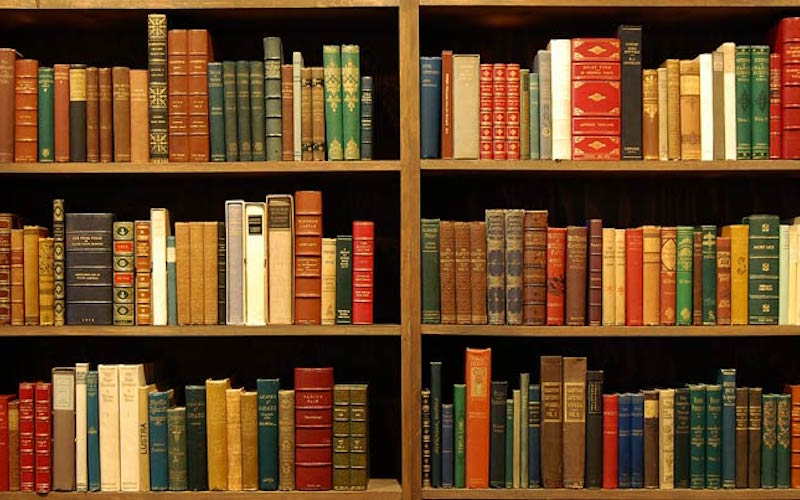

# Import Libraries and Load Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/goodbooks-10k/book_tags.csv
/kaggle/input/goodbooks-10k/ratings.csv
/kaggle/input/goodbooks-10k/books.csv
/kaggle/input/goodbooks-10k/sample_book.xml
/kaggle/input/goodbooks-10k/to_read.csv
/kaggle/input/goodbooks-10k/tags.csv


In [2]:
# load data
ratings=pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")
books=pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")

# EDA - Exploratory Data Analysis

In [3]:
# merge books and ratings, only take needed columns
ratings=pd.merge(books,ratings)
ratings = ratings[['book_id', 'original_title','user_id','rating']]
ratings.dropna(inplace=True) # Remove rows with missing values
ratings.head() # show new dataframe

,book_id,original_title,user_id,rating
0,3,Harry Potter and the Philosopher's Stone,314,3
1,3,Harry Potter and the Philosopher's Stone,588,1
2,3,Harry Potter and the Philosopher's Stone,2077,2
3,3,Harry Potter and the Philosopher's Stone,2487,3
4,3,Harry Potter and the Philosopher's Stone,2900,3


In [4]:
ratings.info() # infos about samples, features and datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77920 entries, 0 to 79700
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   book_id         77920 non-null  int64 
 1   original_title  77920 non-null  object
 2   user_id         77920 non-null  int64 
 3   rating          77920 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


We have 77920 sample, and 4 features. Let's check how many books we have.

In [26]:
ratings.original_title.nunique() # unique number of book titles

794

We have a total of 794 book titles in our dataset.

## Data Visualization

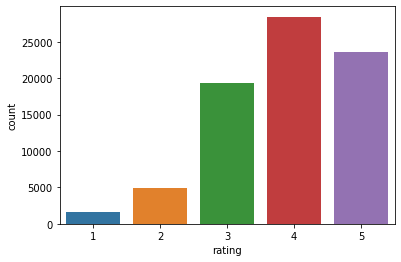

In [6]:
# plot the ratings
sns.countplot(x=ratings.rating);

We can see that most of our rating are above average and only very few of the books got rated 1 or 2.

The following heatmap shows the correlation between the number of ratings and average rating for each book, with warmer colors indicating a stronger correlation.

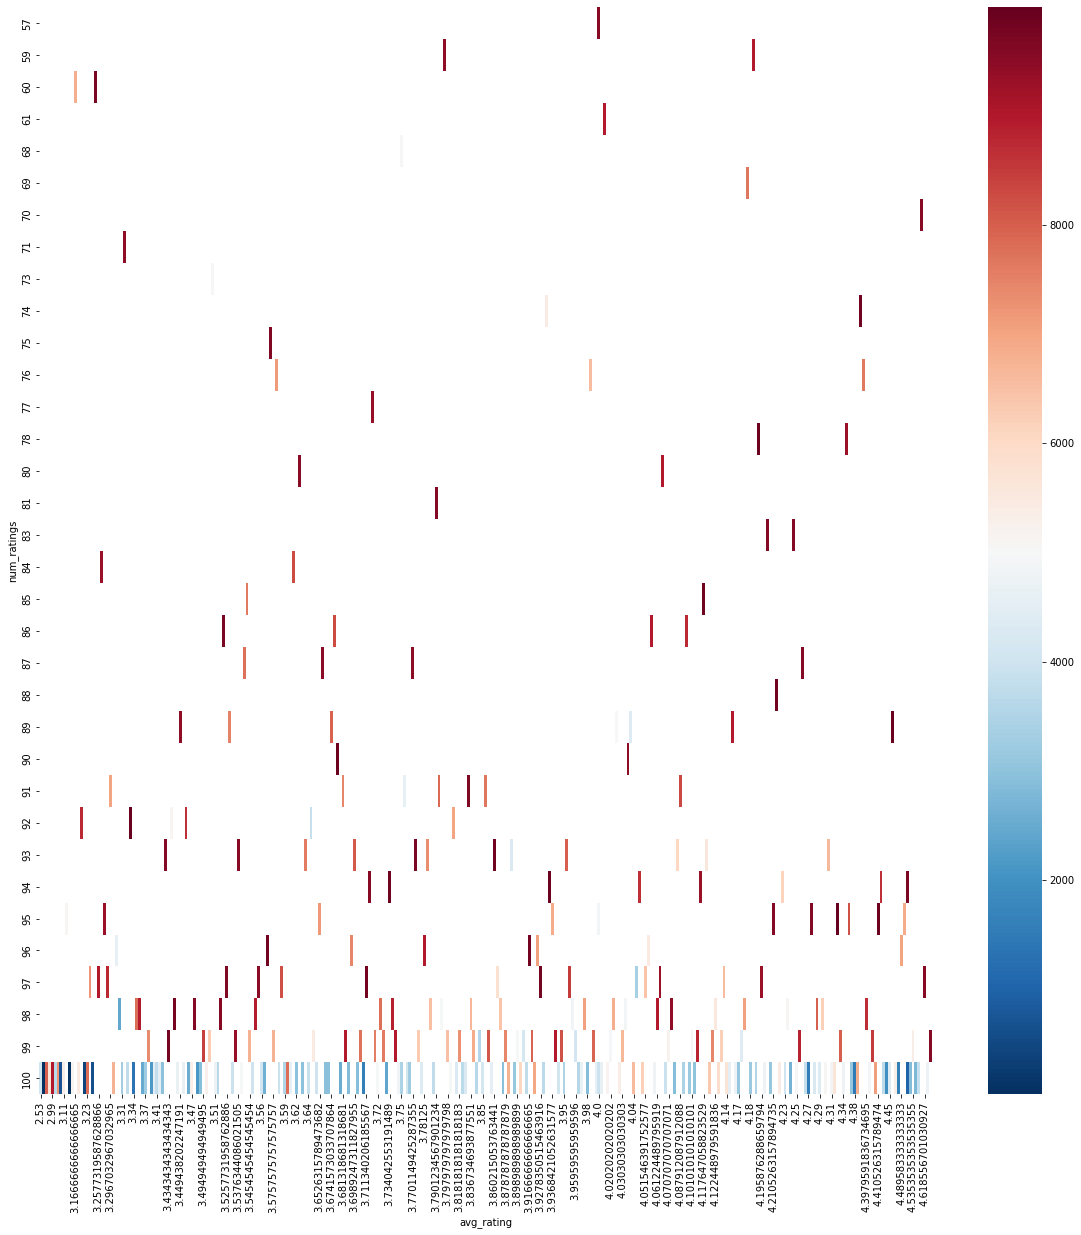

In [7]:
# Group the data by book ID and calculate the number of ratings and average rating for each book
book_ratings = ratings.groupby('book_id').agg({'rating': ['count', 'mean']}).reset_index()
# Rename the columns
book_ratings.columns = ['book_id', 'num_ratings', 'avg_rating']
# Create a pivot table showing the correlation between the number of ratings and average rating for each book
pivot = pd.pivot_table(book_ratings, index='num_ratings', columns='avg_rating', values='book_id')
# Create a heatmap of the pivot table
plt.figure(figsize=(20,20))
sns.heatmap(pivot, cmap='RdBu_r');

Note: I used ChatGPT and fed him my data and our code we learned in the lesson for Recommender Systems. With a troubleshoot of many hours we came to this conclusion. So this is a ChatGPT modified Version of our codes we learned in the lessons a couple of weeks ago.

# Popularity Based Recommender System
Recommending the most populer book:<br>
First we seperate our books to groups and see how many users gave the book a rating. We also calculate the total number and mean value of the ratings. Then we calculate the percentage weight and show all these in a Dataframe, showing the most popular book on top.


In [8]:
# function to calculate popularity stats
def popularity_based_rec(df, group_col, rating_col):
    # group by title and get size, sum and mean values
    grouped = df.groupby(group_col).agg({rating_col: [np.size, np.sum, np.mean]})
    # most popular mean value on top
    popular = grouped.sort_values((rating_col, "mean"), ascending=False)
    total_sum = grouped[rating_col]["sum"].sum() # needed for sum by percentage
    # percentage weight
    popular["percentage"] = popular[rating_col]["sum"].div(total_sum) * 100
    return popular.sort_values(("percentage"), ascending=False)

### Show top 5 books

In [9]:
# call function and show top 5 books
popularity_stats = popularity_based_rec(ratings, "original_title", "rating")
popularity_stats.head() # show top 5 books

rating                 \
                                                     size  sum      mean   
original_title                                                             
Still Life with Woodpecker                             99  473  4.777778   
The Beautiful and Damned                              100  466  4.660000   
The Taste of Home Cookbook                            100  455  4.550000   
A People's History of the United States: 1492 t...    100  454  4.540000   
Girl with a Pearl Earring                             100  453  4.530000   

                                                   percentage  
                                                               
original_title                                                 
Still Life with Woodpecker                           0.157065  
The Beautiful and Damned                             0.154741  
The Taste of Home Cookbook                           0.151088  
A People's History of the United States: 1492 t...   0.150756  
Girl with a Pearl Earring                            0.150424

If we have no information about the users, we should recommend **'Still Life with Woodpecker'**. 99 users gave this book a rating and this book has a total amount of 473 ratings with a mean rating of 4,78 with a 15,71% percentage weight.<br>

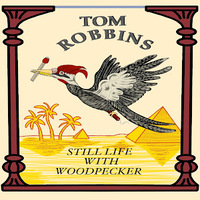

If this was already read by the users we should recommend **'The Beautiful and Damned'**, and so on.

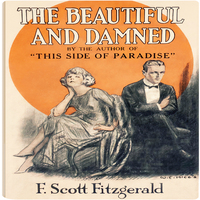

# K-Nearest Neighbor Based Recommender System
A k-nearest neighbor (KNN) based recommender system is a type of collaborative filtering system that uses the ratings given by users to other items to make recommendations. The system works by calculating the similarity between each pair of items, and then using the similarities to predict how a user will rate a given item.

In [10]:
# sort the books from largest to smallest according to its mean ratings
bookProperties = ratings.groupby("book_id").agg({"rating": [np.size, np.mean]})
bookProperties.head()

rating      
          size  mean
book_id             
1          100  4.24
2          100  4.21
3          100  3.09
5          100  3.89
6          100  4.09

In [11]:
# calculate their percentages
bookNumRatings = pd.DataFrame(bookProperties["rating"]["size"])
bookNormalizedNumRatings = bookNumRatings.apply(lambda x: (x-np.min(x)) / (np.max(x) - np.min(x)))
bookNormalizedNumRatings.tail() # show last 5 entries

,size
book_id,
9914,0.860465
9915,0.767442
9943,0.744186
9957,0.813953
9998,0.883721


For example, we see that the distance of the book with id 9914 is 86.What is the closest movie to this?

In [12]:
# save this in output to use in following KNN System
df=pd.read_csv('/kaggle/working/ratings.csv')
df.head()

,Unnamed: 0,book_id,original_title,user_id,rating
0,0,3,Harry Potter and the Philosopher's Stone,314,3
1,1,3,Harry Potter and the Philosopher's Stone,588,1
2,2,3,Harry Potter and the Philosopher's Stone,2077,2
3,3,3,Harry Potter and the Philosopher's Stone,2487,3
4,4,3,Harry Potter and the Philosopher's Stone,2900,3


First we create a dictionary of books. Then we find the distance of a book from another book and get the K-Nearest Neighbors and show them in a list.

In [13]:
# store all books in a dictionary with their id's, names ratings, number of ratings and average ratings
bookDict = {} # create an empty book Dictionary
# Read in the ratings data from the CSV file
with open('ratings.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)  # skip the first row
    for row in csv_reader:
        if row[1] == '' or row[2] == '' or row[3] == '' or row[4] == '':
            continue
        # get the right columns
        bookID = int(row[1])
        name = row[2]
        userID = int(row[3])
        rating = int(row[4])

        if bookID not in bookDict:
            bookDict[bookID] = {'name': name, 'ratings': [], 'numRatings': 0, 'totalRating': 0}
        bookDict[bookID]['ratings'].append(rating)
        bookDict[bookID]['numRatings'] += 1
        bookDict[bookID]['totalRating'] += rating

# Calculate the average rating for each book
for bookID in bookDict:
    book = bookDict[bookID]
    name = book['name']
    ratings = book['ratings']
    numRatings = book['numRatings']
    totalRating = book['totalRating']
    avgRating = totalRating / numRatings
    bookDict[bookID] = {'name': name, 'ratings': ratings, 'numRatings': numRatings, 'avgRating': avgRating}

Let's have a look to our Book Dictionary and how the data is stored.

In [14]:
bookDict

{3: {'name': "Harry Potter and the Philosopher's Stone",
  'ratings': [3,
   1,
   2,
   3,
   3,
   4,
   1,
   4,
   5,
   2,
   4,
   5,
   5,
   3,
   4,
   1,
   2,
   3,
   3,
   1,
   5,
   1,
   1,
   1,
   1,
   2,
   3,
   4,
   1,
   4,
   2,
   4,
   5,
   5,
   1,
   5,
   1,
   1,
   1,
   4,
   4,
   4,
   3,
   5,
   4,
   4,
   2,
   3,
   4,
   4,
   3,
   3,
   1,
   3,
   1,
   3,
   3,
   3,
   3,
   1,
   2,
   4,
   3,
   1,
   4,
   1,
   5,
   4,
   5,
   1,
   3,
   4,
   2,
   1,
   4,
   3,
   5,
   3,
   3,
   5,
   4,
   2,
   2,
   5,
   3,
   1,
   5,
   5,
   5,
   5,
   1,
   5,
   5,
   5,
   5,
   5,
   3,
   2,
   1,
   5],
  'numRatings': 100,
  'avgRating': 3.09},
 2657: {'name': 'To Kill a Mockingbird',
  'ratings': [4,
   2,
   4,
   1,
   3,
   3,
   3,
   3,
   4,
   4,
   3,
   4,
   3,
   3,
   3,
   5,
   5,
   5,
   5,
   5,
   4,
   4,
   3,
   5,
   5,
   4,
   3,
   4,
   4,
   3,
   3,
   5,
   4,
   2,
   4,
   4,
   3,
   4,
   3,
  

In [15]:
bookData = bookDict[8914]
bookData

{'name': 'The First World War',
 'ratings': [3,
  4,
  5,
  3,
  3,
  3,
  4,
  5,
  4,
  4,
  3,
  3,
  3,
  4,
  4,
  5,
  5,
  4,
  4,
  3,
  3,
  1,
  3,
  3,
  5,
  3,
  5,
  4,
  3,
  4,
  4,
  1,
  3,
  5,
  4,
  4,
  4,
  3,
  3,
  2,
  3,
  3,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  3,
  4,
  2,
  2,
  4,
  4,
  3,
  3,
  2,
  4,
  4,
  5,
  4,
  5,
  3,
  3,
  3,
  4,
  4,
  4,
  1,
  4,
  3,
  4,
  4,
  3,
  3,
  5,
  4,
  3,
  4,
  5,
  5,
  3,
  4,
  3,
  4,
  3,
  4,
  3,
  3,
  2,
  4,
  3,
  4,
  4,
  3,
  3,
  4],
 'numRatings': 98,
 'avgRating': 3.5510204081632653}

In [16]:
# function that finds the distance of a book from another book
def ComputeDistance(a, b):
    # Find the common ratings for both books
    common_ratings = [rating for rating in a['ratings'] if rating in b['ratings']]

    # If there are no common ratings, the distance is infinity
    if len(common_ratings) == 0:
        return float('inf')

    # If the lists of ratings are not the same length, return infinity
    if len(a['ratings']) != len(b['ratings']):
        return float('inf')

    # Calculate the sum of the squared differences between the ratings
    sum_squared_differences = sum([(a['ratings'][i] - b['ratings'][i]) ** 2 for i in range(len(common_ratings))])

    # Return the square root of the sum of squared differences, which is the distance between the two books
    return sum_squared_differences ** 0.5

In [17]:
# function to get K-Nearest Neighbors
def getNeighbors(bookID, K):
    # Get the book object for the given book ID
    target_book = bookDict[bookID]

    # Create a list of tuples (distance, bookID) for all books in the dictionary
    distances = [(ComputeDistance(target_book, bookDict[bookID]), bookID) for bookID in bookDict if bookDict[bookID]['name'] != target_book['name']]

    # Sort the list of tuples by distance (ascending)
    distances.sort()

    # Return the K nearest neighbors (books with the lowest distances)
    return distances[:K]

In [18]:
# get the smallest distances as a list
neighbors = getNeighbors(2657, 30)
# Print the book names and distances of the nearest neighbors
for distance, bookID in neighbors:
    print(f"{bookDict[bookID]['name']}: {distance:.2f}")

The Great Gatsby: 10.44
Anil's Ghost: 11.27
Galápagos: 11.27
Timeline: 11.36
Extremely Loud and Incredibly Close: 11.49
Founding Brothers: The Revolutionary Generation: 11.49
Three Complete Novels: Carrie/Salem's Lot/The Shining: 11.53
White Teeth: 11.62
The Pillars of the Earth: 11.70
'Tis: A Memoir: 11.75
Veinte poemas de amor y una canción desesperada: 11.75
The Pearl of the World: 11.83
Live and Let Die: 11.87
Vanity Fair: A Novel Without a Hero: 11.87
The People of Sparks: 11.92
Brokeback Mountain: 11.96
The BFG: 11.96
The Terror: 12.00
Teacher Man: 12.00
Where the Heart Is: 12.00
Breath, Eyes, Memory : 12.00
The Westing Game: 12.04
A Great and Terrible Beauty: 12.04
Post-Mortem:  A Mystery Introducing Dr. Kay Scarpetta: 12.04
The Rescue: 12.08
Skipping Christmas: 12.08
Cien años de soledad: 12.12
Manual do guerreiro da luz: 12.12
A Painted House: 12.12
Breaking the Spell: Religion as a Natural Phenomenon: 12.17


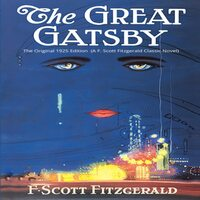

# User Based Recommender System
User Based recommendations Systems are based on the preferences of similar users. It works by identifying users who have similar tastes and recommending items that they have liked.

## Matrix Factorization
Matrix factorization is a technique that is commonly used in recommendation systems to predict the ratings that users will give to items. These matrices can then be used to make predictions about how a user will rate an item by taking the dot product of the user and item vectors.

In [19]:
ratings=pd.read_csv("/kaggle/working/ratings.csv")

In [20]:
# Matrix Factorization (pivot_table)
bookratings=ratings.pivot_table(index=['user_id'],columns=["original_title"],values="rating")
bookratings.head()

original_title,,Animal Farm & 1984,Carter Beats the Devil,The Fellowship of the Ring,"めくらやなぎと、眠る女 [Mekurayanagi to, nemuru onna]",'Salem's Lot The Illustrated Edition,'Tis: A Memoir,1421: The Year China Discovered America,1776,31 Songs,...,Ἰλιάς ; Ὀδύσσεια,Ἰστορίαι,Ὀδύσσεια,Ὀρέστεια,…trotzdem Ja zum Leben sagen: Ein Psychologe erlebt das Konzentrationslager,スプートニクの恋人 [Supūtoniku no Koibito],海辺のカフカ [Umibe no Kafuka],砂の女 [Suna no onna],象の消滅 [Zō no shōmetsu],鋼の錬金術師 1
user_id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# an example of the correaltion between the books '1776' and 'The Fellowship of the Ring'
book1776=bookratings['1776']
bookratings[[" The Fellowship of the Ring","1776"]].corr()

original_title,The Fellowship of the Ring,1776
original_title,,
The Fellowship of the Ring,1.000000,0.707107
1776,0.707107,1.000000


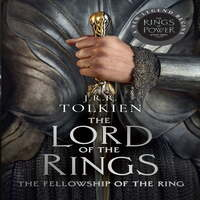 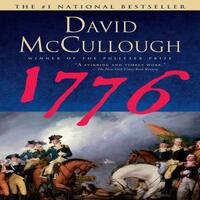

In [22]:
# show books with most correlation
bookratings.corrwith(book1776).sort_values(ascending=False).to_frame('corr')

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,corr
original_title,
鋼の錬金術師 1,1.0
Ἰστορίαι,1.0
A Midsummer Night's Dream,1.0
The Client,1.0
What Do You Care What Other People Think? Further Adventures of a Curious Character,1.0
...,...
…trotzdem Ja zum Leben sagen: Ein Psychologe erlebt das Konzentrationslager,NaN
スプートニクの恋人 [Supūtoniku no Koibito],NaN
海辺のカフカ [Umibe no Kafuka],NaN


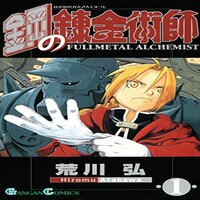 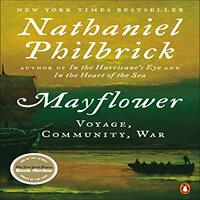

In [23]:
# show books with least correlation
bookratings.corrwith(book1776).sort_values(ascending=True).to_frame('corr').dropna()

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,corr
original_title,
"Mayflower: A Story of Courage, Community, and War",-1.0
Breaking the Spell: Religion as a Natural Phenomenon,-1.0
Pride and Prejudice,-1.0
How to Be Good,-1.0
Year of Wonders: A Novel of the Plague,-1.0
...,...
Ἰστορίαι,1.0
What Do You Care What Other People Think? Further Adventures of a Curious Character,1.0
A Midsummer Night's Dream,1.0


In [24]:
# show a sample of random 15 books and see their correlation
bookratings.corrwith(book1776).to_frame('corr').dropna().sample(15)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,corr
original_title,
Ἰλιάς ; Ὀδύσσεια,1.000000
Neither Here Nor There: Travels in Europe,-0.541736
What Do You Care What Other People Think? Further Adventures of a Curious Character,1.000000
Notes from a Big Country,-0.648886
1421: The Year China Discovered America,0.402911
The Lord of the Rings: The Art of The Fellowship of the Ring,0.500000
Liar's Poker: Rising Through the Wreckage on Wall Street,-0.707107
Λυσιστράτη,-1.000000
The Westing Game,0.797724


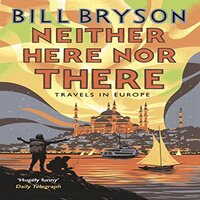

Conclusion: "A Book is always a good Idea"